In [20]:
import numpy as np
import matplotlib.pyplot as plt
import configparser
import glob
from tqdm import tqdm
import h5py as h5

In [33]:
def get_movie_steps(dirname, nframe, iter_max, iter_min=0):
    """
    Obtain evenly-spaced sample of MCMC steps to make movie from
    """
    all_mcmc = glob.glob(dirname + '/mcmc_*.h5')
    x = [m[len(dirname + '/mcmc_'):-3] for m in all_mcmc]
    all_mcmc = np.sort([int(m[len(dirname + '/mcmc_'):-3]) for m in all_mcmc])
    if iter_max >= 0:
        all_mcmc = all_mcmc[all_mcmc <= iter_max]
    all_mcmc = all_mcmc[all_mcmc >= iter_min]
    if nframe > 0:
        max_out = max(all_mcmc)
        min_out = min(all_mcmc)
        step = max(int((max_out - min_out+1) / nframe), 1)
        all_mcmc = all_mcmc[::step]
        if max_out not in all_mcmc:
            all_mcmc = np.concatenate([all_mcmc, [max_out]])
    return all_mcmc

def load_param_samples(ini_name, dirname, nframe, iter_max, iter_min):
    
    config = configparser.ConfigParser()
    config.read(ini_name)
    to_sample = []
    for k,v in config['block_loop'].items():
        if v.strip() == 'false':
            i = k.index('_sampler')
            if k[:i] not in ['hades', 'bias', 'nmean']:
                to_sample.append(k[:i])
    nsamp = int(config['run']['nsamp'])
    new_to_sample = []
    for s in to_sample:
        if s in ['omega_m', 'sigma8', 'sig_v']:
            new_to_sample.append(s)
        elif s == 'bulk_flow':
            for d in ['_x', '_y', '_z']:
                new_to_sample.append(f'{s}{d}')
        else:
            for i in range(nsamp):
                new_to_sample.append(f'{s}{i}')
                
    to_sample = new_to_sample
    
    all_mcmc = get_movie_steps(dirname, nframe, iter_max, iter_min=iter_min)
    samples = np.empty((len(to_sample),len(all_mcmc)))

    for i in tqdm(range(len(all_mcmc))):
        with h5.File(f'{dirname}/mcmc_{all_mcmc[i]}.h5', 'r') as f:
            for j, s in enumerate(to_sample):
                if 'model_params_' + s in f['scalars'].keys():
                    samples[j,i] = f['scalars/model_params_' + s][:][0]
                elif 'model_params_cosmology.' + s in f['scalars'].keys():
                    samples[j,i] = f['scalars/model_params_cosmology.' + s][:][0]
                elif s == 'sig_v':
                    samples[j,i] = float(config['model'][s])
                elif s.startswith('bulk_flow'):
                    if s[-1] == 'x':
                        samples[j,i] = np.array(ast.literal_eval(config['model']['bulk_flow']))[0]
                    elif s[-1] == 'y':
                        samples[j,i] = np.array(ast.literal_eval(config['model']['bulk_flow']))[0]
                    elif s[-1] == 'z':
                        samples[j,i] = np.array(ast.literal_eval(config['model']['bulk_flow']))[0]
                    else:
                        raise NotImplementedError
                else:
                    if s in config[f'cosmology'].keys():
                        samples[j,i] = float(config['cosmology'][s])
                    else:
                        print(s)
                        samples[j,i] = float(config[f'sample_{s[-1]}'][s[:-1]])  
                        
    return to_sample, samples
                

# Plot the non-ic parameters

100%|██████████| 10/10 [00:00<00:00, 207.09it/s]


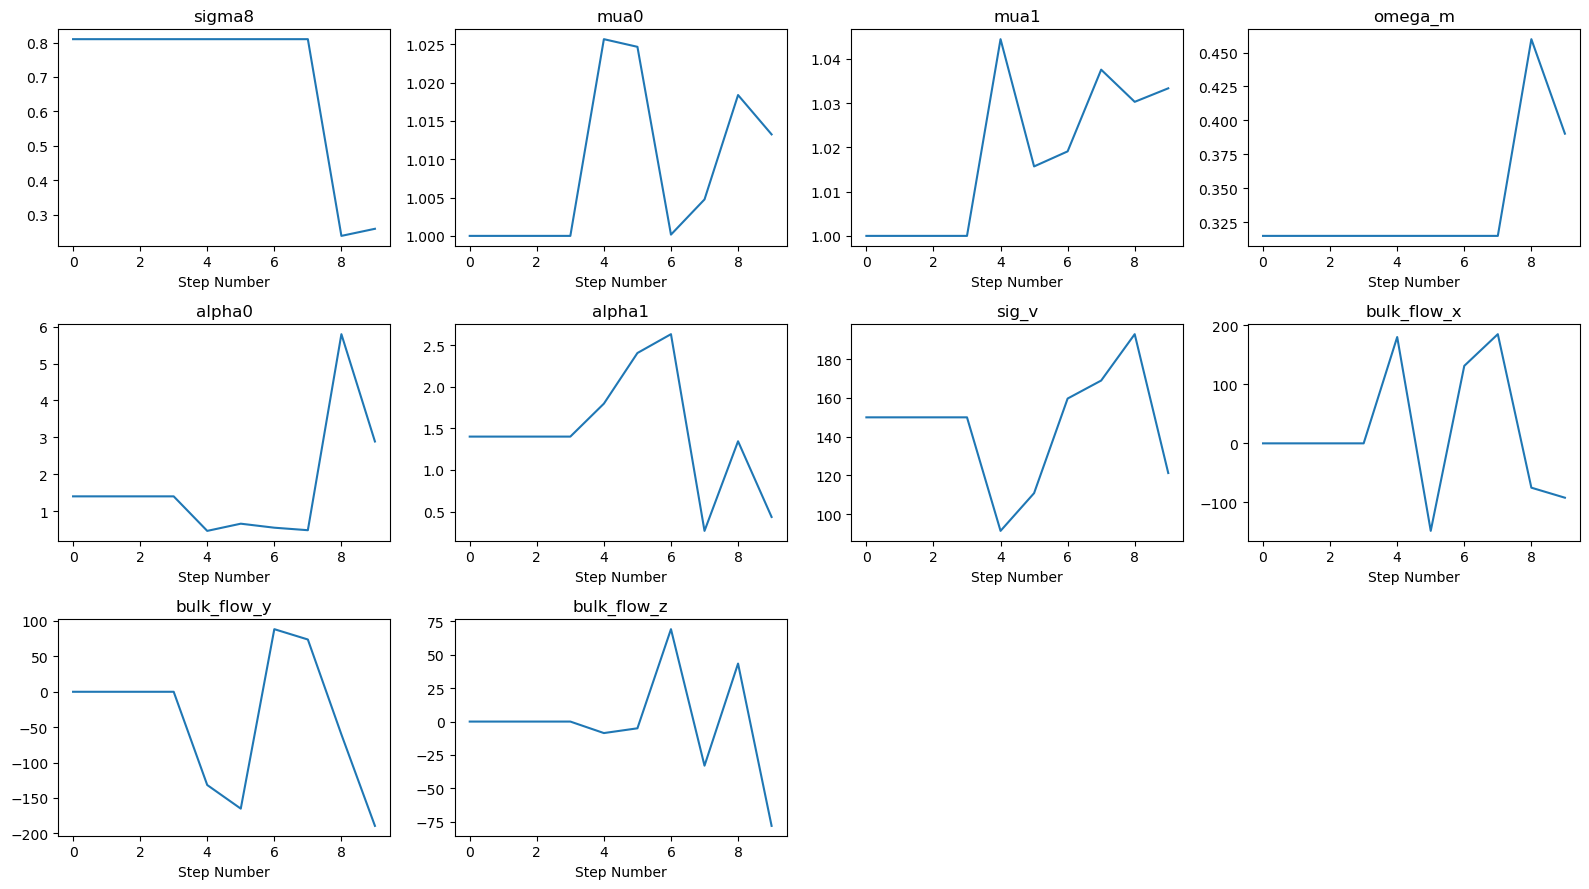

In [41]:
ini_name = '../conf/basic_ini.ini'
dirname = '/data101/bartlett/fsigma8/borg_velocity/basic_run'
nframe = -1
iter_min = -1
iter_max = -1

names, samples = load_param_samples(ini_name, dirname, nframe, iter_max, iter_min)
ncol = 4
nrow = int(np.ceil(len(names) / ncol))

fig, axs = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*3))
axs = np.atleast_2d(axs)
# for i in range(ncol):
    # axs[-1,i].set_xlabel('Step Number')
axs = axs.flatten()
for i in range(len(names)):
    axs[i].plot(samples[i,:])
    axs[i].set_title(names[i])
    axs[i].set_xlabel('Step Number')
for i in range(len(names), len(axs)):
    axs[i].remove()
fig.tight_layout()